In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224
BATCH_SIZE = 16
DATA_PATH = r"C:\Users\HP\Downloads\archive\PlantVillage"


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="categorical"
)

val_gen = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="categorical"
)


Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


In [4]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)


In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 1272s 613ms/step - accuracy: 0.5212 - loss: 1.4305 - val_accuracy: 0.2201 - val_loss: 2.9572
Epoch 2/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 893s 433ms/step - accuracy: 0.5532 - loss: 1.0427 - val_accuracy: 0.2291 - val_loss: 4.3652
Epoch 3/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 732s 354ms/step - accuracy: 0.5570 - loss: 1.0032 - val_accuracy: 0.2553 - val_loss: 4.9887
Epoch 4/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 732s 354ms/step - accuracy: 0.5564 - loss: 0.9885 - val_accuracy: 0.1657 - val_loss: 4.1660
Epoch 5/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 747s 362ms/step - accuracy: 0.5662 - loss: 0.9678 - val_accuracy: 0.1664 - val_loss: 4.7391
Epoch 6/30
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 975s 472ms/step - accuracy: 0.5576 - loss: 0.9585 - val_accuracy: 0.2140 - val_loss: 4.5758


In [9]:
# Unfreeze last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again with a smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again (fine-tuning phase)
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 1027s 494ms/step - accuracy: 0.5437 - loss: 1.2594 - val_accuracy: 0.2225 - val_loss: 4.1569
Epoch 2/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 703s 340ms/step - accuracy: 0.5519 - loss: 1.0049 - val_accuracy: 0.2073 - val_loss: 4.5430
Epoch 3/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 693s 336ms/step - accuracy: 0.5646 - loss: 0.9489 - val_accuracy: 0.2149 - val_loss: 4.5384
Epoch 4/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 702s 340ms/step - accuracy: 0.5617 - loss: 0.9161 - val_accuracy: 0.2058 - val_loss: 4.6635
Epoch 5/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 698s 338ms/step - accuracy: 0.5635 - loss: 0.9013 - val_accuracy: 0.2064 - val_loss: 5.1749
Epoch 6/10
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 770s 373ms/step - accuracy: 0.5612 - loss: 0.8792 - val_accuracy: 0.2021 - val_loss: 5.1674


In [10]:
!pip install tensorflow split-folders matplotlib


In [11]:
import tensorflow as tf
import splitfolders
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [13]:
input_folder = r"C:\Users\HP\Downloads\archive\PlantVillage"# Path to your folder with class subfolders
output_folder = "plant_data_split"

# Split into 80% train, 20% validation
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))

train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")


Copying files: 20639 files [00:56, 364.30 files/s]


In [14]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 16504 images belonging to 16 classes.
Found 4134 images belonging to 16 classes.


In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.5493 - loss: 1.4394 - val_accuracy: 0.8343 - val_loss: 0.5414
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 411s 797ms/step - accuracy: 0.8160 - loss: 0.5627 - val_accuracy: 0.8650 - val_loss: 0.4281
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 351s 681ms/step - accuracy: 0.8360 - loss: 0.4900 - val_accuracy: 0.8628 - val_loss: 0.4123
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 342s 662ms/step - accuracy: 0.8555 - loss: 0.4356 - val_accuracy: 0.8774 - val_loss: 0.3735
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 373s 722ms/step - accuracy: 0.8578 - loss: 0.4184 - val_accuracy: 0.8890 - val_loss: 0.3405
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 350s 678ms/step - accuracy: 0.8593 - loss: 0.4062 - val_accuracy: 0.8926 - val_loss: 0.3276
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 368s 712ms/step - accuracy: 0.8652 - loss: 0.3997 - val_accuracy: 0.8822 - val_loss: 0.3532
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 346s 671ms/step - accuracy: 0.8708 - lo

In [16]:
# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 342s 647ms/step - accuracy: 0.6489 - loss: 1.6244 - val_accuracy: 0.9064 - val_loss: 0.2878
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 323s 626ms/step - accuracy: 0.8385 - loss: 0.4860 - val_accuracy: 0.9020 - val_loss: 0.3161
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 323s 626ms/step - accuracy: 0.8578 - loss: 0.4294 - val_accuracy: 0.9028 - val_loss: 0.2975
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 341s 661ms/step - accuracy: 0.8774 - loss: 0.3644 - val_accuracy: 0.9037 - val_loss: 0.2893
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 359s 696ms/step - accuracy: 0.8893 - loss: 0.3255 - val_accuracy: 0.9107 - val_loss: 0.2621
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 356s 689ms/step - accuracy: 0.8943 - loss: 0.3053 - val_accuracy: 0.9163 - val_loss: 0.2437
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 352s 682ms/step - accuracy: 0.9044 - loss: 0.2822 - val_accuracy: 0.9194 - val_loss: 0.2336
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 351s 679ms/step - accuracy: 0.9108 -

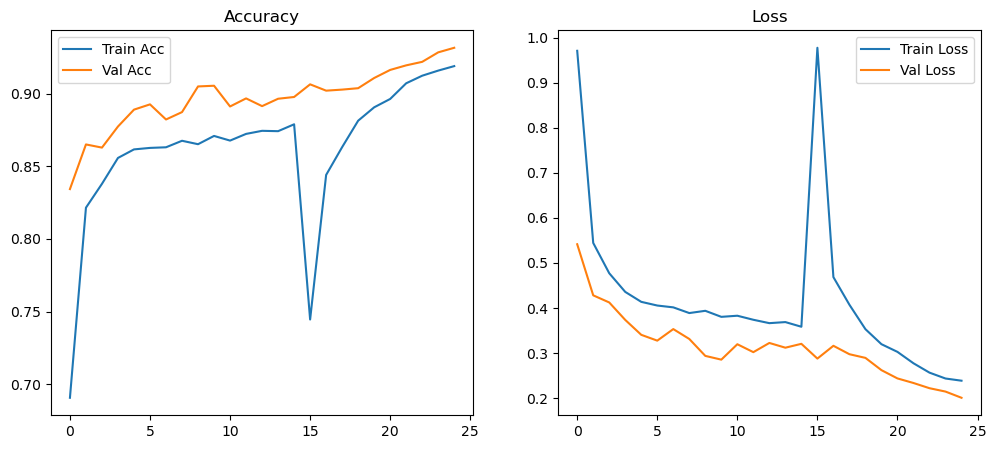

In [17]:
def plot_history(h1, h2=None):
    acc = h1.history['accuracy']
    val_acc = h1.history['val_accuracy']
    loss = h1.history['loss']
    val_loss = h1.history['val_loss']

    if h2:
        acc += h2.history['accuracy']
        val_acc += h2.history['val_accuracy']
        loss += h2.history['loss']
        val_loss += h2.history['val_loss']

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history, history_finetune)


In [19]:
# Save the full model
model.save("CNN_plant_disease_model.h5")
